# Clustering Toronto Nieghborhoods

# Part 1: Scraping Data from Wikipedia Page Using Beautiful Soup Library

In [1]:
import pandas as pd
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
import requests
from bs4 import BeautifulSoup

In [2]:
url = requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")

soup = BeautifulSoup(url.content,'lxml')
table = soup.find_all('table')[0]

df = pd.read_html(str(table))[0]
post_code = df["Postal Code"].tolist()
borough = df["Borough"].tolist()
neighborhood = df["Neighborhood"].tolist()

df.head()

,Postal Code,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


Remove Boroughs that are not assigned

In [3]:
df = df[df.Borough != 'Not assigned']
df.head()

,Postal Code,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


Reorder alphabetically/numerically and check if 'Not assigned' has been removed from Borough

In [4]:
df = df.sort_values('Postal Code',ascending=True)
df.head()

,Postal Code,Borough,Neighborhood
9,M1B,Scarborough,"Malvern, Rouge"
18,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
27,M1E,Scarborough,"Guildwood, Morningside, West Hill"
36,M1G,Scarborough,Woburn
45,M1H,Scarborough,Cedarbrae


In [5]:
df = df.reset_index(drop = True)
df.head()

,Postal Code,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [6]:
'Not assigned' in df['Borough']

False

In [7]:
df.shape

(103, 3)

# Part 2: Adding Latitude and Longitude Coordinates

I struggled to use the Geopackage to gather the coordinates of the neighbourhoods, so I loaded the CSV file given to us.

In [8]:
df2 = pd.read_csv ('https://cocl.us/Geospatial_data')
df2.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [9]:
df2 = df2.sort_values('Postal Code',ascending=True)
df2.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [10]:
final_df = pd.merge(left=df, right=df2, left_on='Postal Code', right_on='Postal Code')
final_df.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


Number of unique Boroughs and Neighborhoods

In [11]:
final_df['Borough'].nunique()

10

In [12]:
final_df['Neighborhood'].nunique()

99

# Part 3: Exploring, Clustering and Mapping

In [13]:
!pip -q install folium
import folium

print('Imports complete')

Imports complete


Before Clustering

In [14]:
torlat = 43.7520
torlon = -79.3832

map_toronto = folium.Map(location=[torlat, torlon], zoom_start=11)

for lat, lng, label in zip(final_df['Latitude'], final_df['Longitude'], final_df['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker([lat, lng],radius=5,popup=label,color='blue',fill=True,fill_color='#3186cc',fill_opacity=0.7,parse_html=False).add_to(map_toronto)  
    
map_toronto

In [15]:
# The code was removed by Watson Studio for sharing.

In [16]:
LIMIT = 100
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
    
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    return(nearby_venues)

In [17]:
toronto_venues = getNearbyVenues(names=final_df['Neighborhood'],latitudes=final_df['Latitude'],longitudes=final_df['Longitude'])


Malvern, Rouge
Rouge Hill, Port Union, Highland Creek
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
Kennedy Park, Ionview, East Birchmount Park
Golden Mile, Clairlea, Oakridge
Cliffside, Cliffcrest, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Wexford Heights, Scarborough Town Centre
Wexford, Maryvale
Agincourt
Clarks Corners, Tam O'Shanter, Sullivan
Milliken, Agincourt North, Steeles East, L'Amoreaux East
Steeles West, L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
York Mills, Silver Hills
Willowdale, Newtonbrook
Willowdale, Willowdale East
York Mills West
Willowdale, Willowdale West
Parkwoods
Don Mills
Don Mills
Bathurst Manor, Wilson Heights, Downsview North
Northwood Park, York University
Downsview
Downsview
Downsview
Downsview
Victoria Village
Parkview Hill, Woodbine Gardens
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto, Broadview North (Old East York)
The Danforth West, 

In [18]:
print(toronto_venues.shape)
toronto_venues.head()

(2125, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Malvern, Rouge",43.806686,-79.194353,Wendy’s,43.807448,-79.199056,Fast Food Restaurant
1,"Malvern, Rouge",43.806686,-79.194353,Interprovincial Group,43.805630,-79.200378,Print Shop
2,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,RIGHT WAY TO GOLF,43.785177,-79.161108,Golf Course
3,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
4,"Guildwood, Morningside, West Hill",43.763573,-79.188711,RBC Royal Bank,43.766790,-79.191151,Bank


In [19]:
toronto_venues.groupby('Neighborhood').count()
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 260 uniques categories.


Considering that there are 2118 Venues, and that it condences down to 273, it shows that many of the neighborhoods share exact shops. Toronto neighborhoods are more condensed therefore

Analysis of Data

In [20]:
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Yoga Studio,Accessories Store,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,Yoga Studio,Accessories Store,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,Agincourt,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.0,0.000000
1,"Alderwood, Long Branch",0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.0,0.000000
2,"Bathurst Manor, Wilson Heights, Downsview North",0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.0,0.000000
3,Bayview Village,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.0,0.000000
4,"Bedford Park, Lawrence Manor East",0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.040000,...,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.0,0.000000
5,Berczy Park,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.017544,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.0,0.000000
6,"Birch Cliff, Cliffside West",0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.0,0.000000
7,"Brockton, Parkdale Village, Exhibition Place",0.041667,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.0,0.000000
8,"Business reply mail Processing Centre, South C...",0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.0,0.000000
9,"CN Tower, King and Spadina, Railway Lands, Har...",0.000000,0.0,0.058824,0.058824,0.058824,0.117647,0.176471,0.117647,0.000000,...,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.0,0.000000


In [22]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Agincourt----
                       venue  freq
0                     Lounge  0.25
1             Breakfast Spot  0.25
2  Latin American Restaurant  0.25
3               Skating Rink  0.25
4                Yoga Studio  0.00


----Alderwood, Long Branch----
            venue  freq
0     Pizza Place  0.22
1        Pharmacy  0.11
2             Pub  0.11
3             Gym  0.11
4  Sandwich Place  0.11


----Bathurst Manor, Wilson Heights, Downsview North----
           venue  freq
0           Bank  0.11
1    Coffee Shop  0.11
2          Diner  0.05
3  Deli / Bodega  0.05
4  Shopping Mall  0.05


----Bayview Village----
                        venue  freq
0         Japanese Restaurant  0.25
1                        Bank  0.25
2          Chinese Restaurant  0.25
3                        Café  0.25
4  Modern European Restaurant  0.00


----Bedford Park, Lawrence Manor East----
                venue  freq
0  Italian Restaurant  0.08
1      Sandwich Place  0.08
2          Restaurant  0.08
3

In [23]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [24]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head(10)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Lounge,Latin American Restaurant,Skating Rink,Breakfast Spot,Dog Run,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center
1,"Alderwood, Long Branch",Pizza Place,Gym,Coffee Shop,Dance Studio,Pharmacy,Skating Rink,Sandwich Place,Pub,Women's Store,Dessert Shop
2,"Bathurst Manor, Wilson Heights, Downsview North",Bank,Coffee Shop,Mobile Phone Shop,Sandwich Place,Middle Eastern Restaurant,Supermarket,Restaurant,Ice Cream Shop,Deli / Bodega,Fried Chicken Joint
3,Bayview Village,Café,Bank,Japanese Restaurant,Chinese Restaurant,Women's Store,Department Store,Dim Sum Restaurant,Diner,Discount Store,Distribution Center
4,"Bedford Park, Lawrence Manor East",Coffee Shop,Sandwich Place,Italian Restaurant,Thai Restaurant,Restaurant,Pizza Place,Pharmacy,Café,Indian Restaurant,Pub
5,Berczy Park,Coffee Shop,Cocktail Bar,Farmers Market,Café,Bakery,Restaurant,Beer Bar,Seafood Restaurant,Cheese Shop,Pharmacy
6,"Birch Cliff, Cliffside West",Café,College Stadium,Skating Rink,General Entertainment,Distribution Center,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store
7,"Brockton, Parkdale Village, Exhibition Place",Café,Performing Arts Venue,Breakfast Spot,Coffee Shop,Bakery,Stadium,Burrito Place,Restaurant,Climbing Gym,Pet Store
8,"Business reply mail Processing Centre, South C...",Gym / Fitness Center,Garden,Brewery,Light Rail Station,Spa,Farmers Market,Fast Food Restaurant,Burrito Place,Restaurant,Auto Workshop
9,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Service,Airport Terminal,Airport Lounge,Boat or Ferry,Rental Car Location,Coffee Shop,Harbor / Marina,Boutique,Sculpture Garden,Airport Gate


In [25]:
neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['Neighborhood']=='Bank']

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue


Looking at the top venues, it seems that the number one is most occupied the service industry, i.e. food, entertainment or services (airports). Food is incredibly popular across the top 10 values in general. The top 10 also does not contain many non-entertainment venues. For example, there are no banks found in the top 10 venues.

Calculating optimal K values using elbow algorithm for K-means

In [26]:
distortions = []
K = range(1,15)
toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(toronto_grouped_clustering)
    distortions.append(kmeanModel.inertia_)

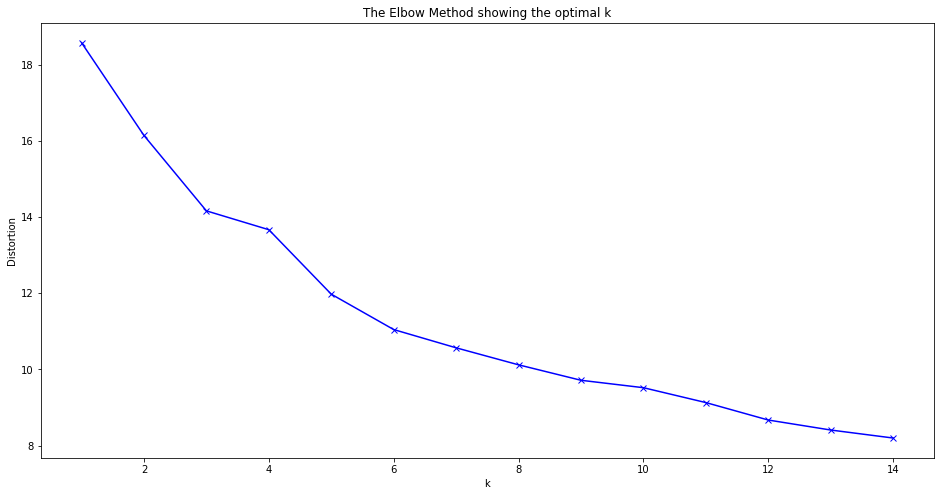

In [27]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

Elbow at 10 - also 10 unique boroughs

In [28]:
kclusters = 10
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)
kmeans.labels_[0:10]
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [29]:
toronto_merged = final_df
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood', how='right')

toronto_merged.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353,7,Print Shop,Fast Food Restaurant,Dog Run,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Women's Store
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,6,Golf Course,Bar,Women's Store,Distribution Center,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,1,Mexican Restaurant,Electronics Store,Restaurant,Breakfast Spot,Rental Car Location,Intersection,Medical Center,Bank,Women's Store,Dim Sum Restaurant
3,M1G,Scarborough,Woburn,43.770992,-79.216917,1,Coffee Shop,Convenience Store,Korean Restaurant,Insurance Office,Dog Run,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,1,Fried Chicken Joint,Gas Station,Bank,Hakka Restaurant,Lounge,Athletics & Sports,Caribbean Restaurant,Thai Restaurant,Bakery,Department Store


In [30]:
map_clusters = folium.Map(location=[torlat, torlon], zoom_start=11)

x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Cluster 0

In [31]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
13,Scarborough,0,Pharmacy,Pizza Place,Fried Chicken Joint,Fast Food Restaurant,Italian Restaurant,Thai Restaurant,Chinese Restaurant,Gas Station,Convenience Store,Noodle House
15,Scarborough,0,Fast Food Restaurant,Chinese Restaurant,Coffee Shop,Grocery Store,Gym,Breakfast Spot,Noodle House,Pharmacy,Pizza Place,Supermarket
24,North York,0,Pharmacy,Discount Store,Grocery Store,Pizza Place,Coffee Shop,Bank,Department Store,Dessert Shop,Dim Sum Restaurant,Diner
34,North York,0,Hockey Arena,Pizza Place,Coffee Shop,Portuguese Restaurant,Women's Store,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner
35,East York,0,Pizza Place,Gym / Fitness Center,Athletics & Sports,Gastropub,Intersection,Fast Food Restaurant,Pet Store,Café,Bank,Pharmacy
39,East York,0,Indian Restaurant,Sandwich Place,Yoga Studio,Pharmacy,Bank,Intersection,Restaurant,Fast Food Restaurant,Burger Joint,Supermarket
80,York,0,Convenience Store,Sandwich Place,Bar,Discount Store,Distribution Center,Dessert Shop,Dim Sum Restaurant,Diner,Women's Store,Deli / Bodega
81,York,0,Grocery Store,Bus Line,Brewery,Pizza Place,Electronics Store,Eastern European Restaurant,Drugstore,Donut Shop,Doner Restaurant,Deli / Bodega
89,Etobicoke,0,Pizza Place,Gym,Coffee Shop,Dance Studio,Pharmacy,Skating Rink,Sandwich Place,Pub,Women's Store,Dessert Shop
95,Etobicoke,0,Pharmacy,Beer Store,Pet Store,Pizza Place,Coffee Shop,Café,Liquor Store,General Entertainment,Donut Shop,Dog Run


Cluster 1

In [32]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Scarborough,1,Mexican Restaurant,Electronics Store,Restaurant,Breakfast Spot,Rental Car Location,Intersection,Medical Center,Bank,Women's Store,Dim Sum Restaurant
3,Scarborough,1,Coffee Shop,Convenience Store,Korean Restaurant,Insurance Office,Dog Run,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center
4,Scarborough,1,Fried Chicken Joint,Gas Station,Bank,Hakka Restaurant,Lounge,Athletics & Sports,Caribbean Restaurant,Thai Restaurant,Bakery,Department Store
6,Scarborough,1,Hobby Shop,Chinese Restaurant,Bus Station,Discount Store,Department Store,Coffee Shop,Drugstore,Donut Shop,Doner Restaurant,Dog Run
7,Scarborough,1,Bakery,Soccer Field,Metro Station,Park,Ice Cream Shop,Intersection,Bus Station,Bus Line,Diner,Discount Store
8,Scarborough,1,American Restaurant,Motel,Movie Theater,Dance Studio,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Women's Store
9,Scarborough,1,Café,College Stadium,Skating Rink,General Entertainment,Distribution Center,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store
10,Scarborough,1,Indian Restaurant,Vietnamese Restaurant,Thrift / Vintage Store,Chinese Restaurant,Pet Store,Donut Shop,Doner Restaurant,Dog Run,Distribution Center,Curling Ice
11,Scarborough,1,Smoke Shop,Breakfast Spot,Bakery,Middle Eastern Restaurant,Women's Store,Department Store,Eastern European Restaurant,Drugstore,Donut Shop,Doner Restaurant
12,Scarborough,1,Lounge,Latin American Restaurant,Skating Rink,Breakfast Spot,Dog Run,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center


Cluster 1 is good if you like food, as there is a large variety

Cluster 2

In [33]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
91,Etobicoke,2,Baseball Field,Women's Store,Deli / Bodega,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Drugstore,Donut Shop,Doner Restaurant,Dog Run
97,North York,2,Baseball Field,Women's Store,Deli / Bodega,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Drugstore,Donut Shop,Doner Restaurant,Dog Run


Cluster 2 contain the exact same popularity for the top 10 venues, and holds a variety of food and outdoor activities

Cluster 3

In [34]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
14,Scarborough,3,Playground,Park,Women's Store,Discount Store,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Dog Run
25,North York,3,Park,Food & Drink Shop,Women's Store,Distribution Center,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run
44,Central Toronto,3,Park,Bus Line,Swim School,Women's Store,Discount Store,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Distribution Center
48,Central Toronto,3,Park,Trail,Tennis Court,Playground,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner
50,Downtown Toronto,3,Park,Playground,Trail,Discount Store,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Distribution Center
64,Central Toronto,3,Park,Sushi Restaurant,Jewelry Store,Trail,Discount Store,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Distribution Center
74,York,3,Park,Women's Store,Pool,Discount Store,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Dog Run
90,Etobicoke,3,Park,River,Women's Store,Discount Store,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Distribution Center
98,York,3,Park,Women's Store,Dance Studio,Electronics Store,Eastern European Restaurant,Drugstore,Donut Shop,Doner Restaurant,Dog Run,Distribution Center


Cluster 3 is clustered by it's parks being the most popular venue

Cluster 4

In [35]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
63,Central Toronto,4,Garden,Women's Store,Dance Studio,Electronics Store,Eastern European Restaurant,Drugstore,Donut Shop,Doner Restaurant,Dog Run,Distribution Center


Cluster 4 has a variety of shops and food venues

Cluster 5

In [36]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 5, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Scarborough,5,Spa,Playground,Distribution Center,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run


Cluster 5 has a variety of venues with spa being the most popular

Cluster 6

In [37]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 6, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Scarborough,6,Golf Course,Bar,Women's Store,Distribution Center,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run
94,Etobicoke,6,Golf Course,Women's Store,Dance Studio,Electronics Store,Eastern European Restaurant,Drugstore,Donut Shop,Doner Restaurant,Dog Run,Distribution Center


Cluster 6 is clustered by golf courses

Cluster 7

In [38]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 7, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Scarborough,7,Print Shop,Fast Food Restaurant,Dog Run,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Women's Store


Cluster 7 has the print shop as the most popular

Cluster 8

In [39]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 8, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
23,North York,8,Electronics Store,Park,Convenience Store,Women's Store,Distribution Center,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store
40,East York,8,Park,Pizza Place,Convenience Store,Discount Store,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Distribution Center


Cluster 8 shares similar popular venues like parks, convenience stores, department stores, dessert shop, dim sum discount store and distribution center

Cluster 9

In [40]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 9, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
96,North York,9,Gym,Event Space,Electronics Store,Eastern European Restaurant,Drugstore,Donut Shop,Doner Restaurant,Dog Run,Distribution Center,Discount Store


Cluster 9 has the gym as being it's most popular venue